In [37]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score

from control_systems.car_hillclimbing import HillClimbingCar
from pid_controller import PIDController
from anomaly_detection import CUSUMDetector

In [29]:
# CUSUM Tuning
cusum_thresholds = np.arange(2, 20, 0.5)
cusum_bs = np.arange(1, 13, 0.5)
best_f1 = float("-inf")
best_thres = 0
best_b = 0
for thres in cusum_thresholds:
    for cusum_b in cusum_bs:
        env = HillClimbingCar()

        run_tracker = env.run_control_system(   
                config={
                        "params": {
                            "m": 1200,       # Mass (kg)
                            "g": 9.81,       # Gravity (m/s^2)
                            "Cr": 0.01,      # Rolling resistance coefficient
                            "Cd": 0.3,       # Aerodynamic drag coefficient
                            "A": 2.2,        # Frontal area (m^2)
                            "rho": 1.225,    # Air density (kg/m^3)
                            "Fmax": 40000,    # Maximum engine force (N)
                        },
                        "init-state": np.array([0, 20]),  # [Position (m), Velocity (m/s)]
                        "dt": 0.1,
                        "time": 500,
                        "attack-start": 10,
                        "attack-end": 20,
                        "v-controller": PIDController(0.5, 0.5, 0.01),
                        "target-velocity": 20,
                        "process-noise-cov": np.diag([0.01, 0.1]),
                        "measurement-noise-cov": 0.2,
                        "anomaly-detector": CUSUMDetector(
                            thresholds=thres*np.array([0.16000361755278]),
                            b=np.array([0.18543593999687008]) + cusum_b*np.array([0.16000361755278])),
                    },
                show_plots=False
            )

        time = np.arange(0, 500, 0.1)
        attack_labels = [(x >= 10 and x <= 20) for x in time]
        attack_predictions = run_tracker.get_metrics(metric="attack_predictions")
        cm = confusion_matrix(attack_predictions, attack_predictions)
        prec = precision_score(attack_labels, attack_predictions)
        rec = recall_score(attack_labels, attack_predictions)
        acc = accuracy_score(attack_labels, attack_predictions)
        f1 = f1_score(attack_labels, attack_predictions)
        if f1 > best_f1:
            best_thres = thres
            best_b = cusum_b
            best_f1 = f1
            best_acc = acc
            best_rec = rec
            best_prec = prec
    print(f"-----------------\nParams: {best_thres, best_b}\nAccuracy: {best_acc}\nPrecision: {best_prec}\nRecall: {best_rec}")





/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:

-----------------
Params: (10.5, 7.5)
Accuracy: 0.999
Precision: 0.9897959183673469
Recall: 0.9603960396039604


In [59]:
# MSE
mmsce2 = []
for mag in range(1, 10):
    msce = []
    for _ in range(100):
        env = HillClimbingCar()
        run_tracker = env.run_control_system(   
            config={
                    "params": {
                        "m": 1200,       # Mass (kg)
                        "g": 9.81,       # Gravity (m/s^2)
                        "Cr": 0.01,      # Rolling resistance coefficient
                        "Cd": 0.3,       # Aerodynamic drag coefficient
                        "A": 2.2,        # Frontal area (m^2)
                        "rho": 1.225,    # Air density (kg/m^3)
                        "Fmax": 40000,    # Maximum engine force (N)
                    },
                    "init-state": np.array([0, 20]),  # [Position (m), Velocity (m/s)]
                    "dt": 0.1,
                    "time": 50,
                    "attack-start": 10,
                    "attack-end": 20,
                    "attack-magnitude": mag,
                    "v-controller": PIDController(0.5, 0.5, 0.01),
                    "target-velocity": 20,
                    "process-noise-cov": np.diag([0.01, 0.1]),
                    "measurement-noise-cov": 0.2,
                    "anomaly-detector": CUSUMDetector(
                        thresholds=10.5*np.array([0.16000361755278]),
                        b=np.array([0.18543593999687008]) + 7.5*np.array([0.16000361755278])),
                },
            show_plots=False
        )
        msce.append(np.mean(run_tracker.ms_control_error()))
    mmsce2.append(msce)


In [55]:
np.mean(msce), np.std(msce)

(6.945416828981613, 1.5582852595428953)

In [60]:
mmsce

[[1.2394993530961018,
  0.716866138378243,
  1.1581001396330879,
  1.1389033716844101,
  1.0945523267092965,
  1.7091209689987186,
  0.706034109934616,
  3.4828932197553297,
  0.7344541354703757,
  6.311446339175192,
  2.54567317878616,
  1.0535296626612074,
  1.8066019725535976,
  1.3755983297873395,
  1.1057262937590928,
  2.881783302155693,
  1.4976330250388534,
  0.7558491138881993,
  6.060332259576027,
  3.997509315922697,
  5.962353706069826,
  0.7004465416496831,
  0.8282993775018788,
  0.9483777670833048,
  1.1497341932706537,
  6.541297413143342,
  1.6139683762919166,
  5.137223028486922,
  2.218280187335575,
  2.409805344608582,
  3.938866757738063,
  6.369770293690431,
  1.1764569069653537,
  1.5695516908387863,
  1.438501917056007,
  7.624018800746597,
  14.960414406451992,
  1.8759742672216437,
  1.0286292609757757,
  2.4498358705841037,
  1.6742153115835692,
  3.2977135958103525,
  0.7715838604345964,
  1.590671280377795,
  3.4219876318813736,
  2.130609104344831,
  2.475

In [61]:
mmsce2

[[1.5251730983538587,
  2.1582316307355347,
  5.007142021239392,
  3.6561127155290154,
  2.9172005080130834,
  0.8416749831022722,
  1.9383284038341022,
  6.42452664311261,
  1.223095026554377,
  3.1573774291053285,
  2.341583516456729,
  1.657607064800578,
  2.1488891994528045,
  7.218700789020254,
  0.8782201954205016,
  1.3205303742761794,
  0.6992833752095161,
  1.9745663972816805,
  1.4835476709766857,
  0.9132654789292409,
  2.618703745312464,
  10.894040518286682,
  0.5299272252342319,
  1.6613053160726925,
  6.760011163264392,
  2.4490572980596834,
  0.6675312552638144,
  6.3960449922808005,
  0.9079793649425546,
  1.0675875281791793,
  1.4202443638319577,
  5.54011070800346,
  1.2827251306533975,
  4.480590951983375,
  17.269447112547283,
  11.235723799333984,
  1.8590750002474126,
  17.17600049209218,
  1.09416955712739,
  29.744775263561344,
  1.2016916867263923,
  8.015605455655335,
  4.235536469712787,
  0.8669386727329991,
  3.254980349305943,
  2.908568947025157,
  7.768

In [62]:
stats_base = [(np.mean(x), np.std(x)) for x in mmsce]
stats_ekf = [(np.mean(x), np.std(x)) for x in mmsce2]

In [63]:
stats_base

[(2.832507781423014, 2.731966852696139),
 (2.906980539729489, 2.3189911477739122),
 (3.974419222679005, 2.8821740646782383),
 (5.537558540264455, 2.6694691515266897),
 (6.988408049771854, 2.927412225644281),
 (9.073915296944083, 1.6407056926518482),
 (12.315243616441679, 2.469814534505944),
 (15.5058404754815, 2.0476267257742724),
 (20.36054567598587, 2.653298301283018)]

In [64]:
stats_ekf

[(4.291068675995974, 4.583600381541723),
 (5.493661806515961, 7.155542485222117),
 (4.293363980709232, 5.160414171290278),
 (4.44336095821563, 4.470654243522835),
 (5.201131238377831, 5.4657732726985655),
 (5.792390113324972, 7.833562170562348),
 (5.529581769538132, 3.9235456914677393),
 (6.270337314794597, 3.901243670583415),
 (7.22152837068931, 4.075659918571724)]

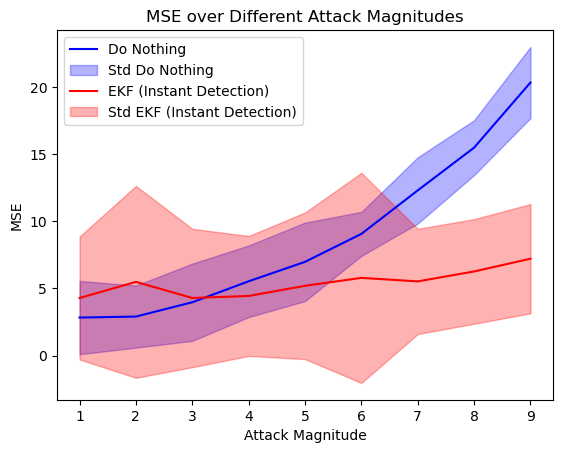

In [68]:
plt.plot(range(1, 10), [x[0] for x in stats_base], color="blue", label="Do Nothing")
plt.fill_between(range(1, 10), [-x[1]+x[0] for x in stats_base], [x[1] + x[0] for x in stats_base], color="blue", alpha=0.3, label="Std Do Nothing")
plt.plot(range(1, 10), [x[0] for x in stats_ekf], color="red", label="EKF (Instant Detection)")
plt.fill_between(range(1, 10), [-x[1] + x[0] for x in stats_ekf], [x[1] + x[0] for x in stats_ekf], color="red", alpha=0.3, label="Std EKF (Instant Detection)")
plt.title("MSE over Different Attack Magnitudes")
plt.xlabel("Attack Magnitude")
plt.ylabel("MSE")
plt.legend()
plt.show()

### PID-Tuning CarHillclimber

In [79]:


def pid_loss_fn(theta):
    Kp, Ki, Kd = theta
    env = HillClimbingCar()
    init_speed = 30*np.random.rand()

    tracker = env.run_control_system(
        config={
            "params": {
                "m": 1200,       # Mass (kg)
                "g": 9.81,       # Gravity (m/s^2)
                "Cr": 0.01,      # Rolling resistance coefficient
                "Cd": 0.3,       # Aerodynamic drag coefficient
                "A": 2.2,        # Frontal area (m^2)
                "rho": 1.225,    # Air density (kg/m^3)
                "Fmax": 40000,    # Maximum engine force (N)
            },
            "init-state": np.array([0, init_speed]),  # [Position (m), Velocity (m/s)]
            "dt": 0.1,
            "time": 50,
            "attack-start": -10,
            "attack-end": -20,
            "attack-magnitude": 0.0,
            "v-controller": PIDController(Kp, Ki, Kd),
            "target-velocity": 20,
            "process-noise-cov": np.diag([0.01, 0.1]),
            "measurement-noise-cov": 0.2,
            "anomaly-detector": CUSUMDetector(
                thresholds=10.5*np.array([0.16000361755278]),
                b=np.array([0.18543593999687008]) + 7.5*np.array([0.16000361755278])),
        },
        show_plots=False
    )

    loss = 0.1*tracker.ms_control_error().sum() / 50
    return loss

def compute_gradient(theta, delta):

    loss = pid_loss_fn(theta + delta*np.array([1,0,0]))
    dKp = (loss - pid_loss_fn(theta-delta*np.array([1,0,0]))) / (2*delta)
    dKi = (pid_loss_fn(theta + delta*np.array([0,1,0])) - pid_loss_fn(theta-delta*np.array([0,1,0]))) / (2*delta)
    dKd = (pid_loss_fn(theta + delta*np.array([0,0,1])) - pid_loss_fn(theta-delta*np.array([0,0,1]))) / (2*delta)

    return np.array([dKp, dKi, dKd]), loss


Loss at Step 0: 3.0037719533577474
Loss at Step 10: 2.927474337379327
Loss at Step 20: 2.9633476495605144
Loss at Step 30: 7.155367970599867
Loss at Step 40: 1.7771367539715197
Loss at Step 50: 2.3698208923820676
Loss at Step 60: 2.938858163643798
Loss at Step 70: 3.3950813005328566
Loss at Step 80: 6.849204407188466
Loss at Step 90: 4.208755873660497
Loss at Step 100: 7.243096497025303
Loss at Step 110: 3.7786366038266
Loss at Step 120: 2.3007914752876535
Loss at Step 130: 3.525039961031973
Loss at Step 140: 5.748587354761313
Loss at Step 150: 2.012506227575544
Loss at Step 160: 0.9018418275447868
Loss at Step 170: 2.224566112711632
Loss at Step 180: 4.2188847354054335
Loss at Step 190: 2.4068731557488063
Loss at Step 200: 4.654363358683967
Loss at Step 210: 3.714806677437826
Loss at Step 220: 3.0573926532193045
Loss at Step 230: 2.546007089875316
Loss at Step 240: 1.7589758372088602
Loss at Step 250: 14.891062618170876
Loss at Step 260: 1.9286967517379288
Loss at Step 270: 1.92640728

Text(0.5, 1.0, 'PID Controller Loss Function')

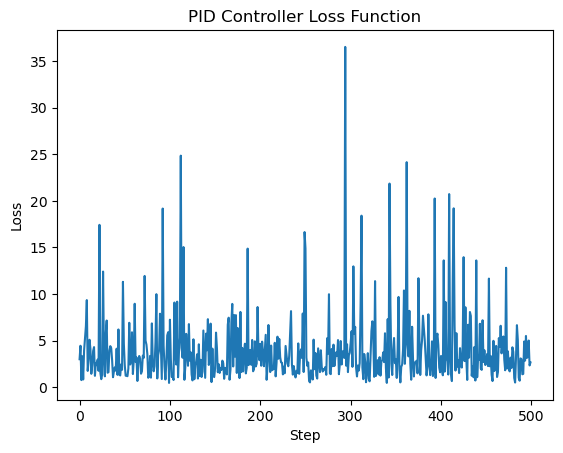

In [80]:
delta = 1e-5
theta0 = np.array([0.5, 0.5, 0.01])
lr = 1e-4
NBR_STEPS = 500


losses = []
theta = theta0
best_theta = theta0
best_loss = float("inf")
for step in range(NBR_STEPS):
    # Compute Gradient
    grad, loss = compute_gradient(theta, delta)
    grad = (1 / np.linalg.norm(grad, 2)) * grad
    
    # Gradient Descent
    theta = theta - lr*grad
    losses.append(loss)
    if loss < best_loss:
        best_theta = theta
    if step % 10 == 0:
        print(f"Loss at Step {step}: {loss}")

plt.plot(range(NBR_STEPS), losses)
plt.ylabel("Loss")
plt.xlabel("Step")
plt.title("PID Controller Loss Function")


In [81]:
best_theta

array([0.50320036, 0.50027134, 0.00711447])

### Data Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# file = f"./data/{sorted(os.listdir("./data"))[-1]}"
file = "./data/car_data_2025-02-1114:06:55.108511.csv"
print(file)
df = pd.read_csv(file)
df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)

./data/car_data_2025-02-1114:06:55.108511.csv


In [2]:
df.head()

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred
0,0.00,0.000000,19.000000,0.000000,19.000000,20.007115,-0.007186,False,False
1,0.01,0.238958,19.002871,0.183539,19.502291,17.323965,1.000000,False,False
2,0.02,0.400311,19.055799,0.385923,18.441115,18.758703,1.000000,False,False
3,0.03,0.574835,19.131765,0.569519,18.628017,18.401579,1.000000,False,False
4,0.04,0.759221,19.147955,0.756689,18.542884,18.173964,1.000000,False,False


In [312]:
df['abs_est_error'] = (df.vel - df.est_vel).apply(lambda x: np.abs(x))
df.head()

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred,abs_est_error
0,0.00,0.000000,19.000000,0.000000,19.000000,21.114374,-0.117009,False,False,0.000000
1,0.01,0.199748,18.923724,0.176234,20.036675,18.002440,0.204172,False,False,1.112950
2,0.02,0.415641,18.970858,0.383711,19.052371,18.866058,0.123480,False,False,0.081513
3,0.03,0.652599,18.983735,0.574960,18.978688,19.598219,0.052273,False,False,0.005047
4,0.04,0.813331,19.014459,0.762813,19.296081,18.654250,0.153398,False,False,0.281622


In [3]:
df.iloc[0:20]

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred
0,0.00,0.000000,19.000000,0.000000,19.000000,20.007115,-0.007186,False,False
1,0.01,0.238958,19.002871,0.183539,19.502291,17.323965,1.000000,False,False
2,0.02,0.400311,19.055799,0.385923,18.441115,18.758703,1.000000,False,False
3,0.03,0.574835,19.131765,0.569519,18.628017,18.401579,1.000000,False,False
4,0.04,0.759221,19.147955,0.756689,18.542884,18.173964,1.000000,False,False
5,0.05,0.931791,19.165957,0.943450,18.386513,18.370550,1.000000,False,False
6,0.06,1.160927,19.180706,1.127539,18.406637,19.883414,0.207393,False,False
7,0.07,1.390554,19.187072,1.307055,19.150041,19.151259,0.948035,False,False
8,0.08,1.595785,19.259332,1.498723,19.177192,18.718399,1.000000,False,False
9,0.09,1.708818,19.288352,1.692163,18.975841,19.154236,0.966332,False,False


In [4]:
df.describe()

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal
count,5000.0000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,24.9950,498.381205,19.922273,499.616586,19.999153,19.999509,0.209688
std,14.4352,288.384233,0.327513,289.166207,0.627641,1.053880,0.742290
min,0.0000,0.000000,18.526106,0.000000,17.187301,15.997354,-1.000000
25%,12.4975,247.385041,19.778595,248.024212,19.599859,19.292841,-0.434547
50%,24.9950,497.747983,19.931321,499.964501,19.998965,19.970194,0.338614
75%,37.4925,748.378559,20.082339,749.969915,20.412344,20.690022,1.000000
max,49.9900,996.816503,21.311402,1000.038033,22.595705,24.166722,1.000000


In [315]:
df.iloc[1000:2000].describe()

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,abs_est_error
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,14.995000,290.317992,18.609539,282.634588,16.467601,23.638462,0.086608,2.148107
std,2.888194,53.605398,0.552316,47.656647,0.578488,1.149493,0.080643,0.957377
min,10.000000,198.282932,17.764999,199.720571,15.504683,20.248089,-0.471650,0.214067
25%,12.497500,243.641536,18.126752,241.228668,15.961445,22.830788,0.012682,1.306463
50%,14.995000,288.901213,18.384155,283.532089,16.650141,23.602724,0.123532,1.566573
75%,17.492500,336.661201,19.130645,323.991225,16.865271,24.413508,0.153672,3.196528
max,19.990000,384.479135,19.892367,363.619214,21.910310,27.608688,0.290654,3.645885


In [316]:
df.iloc[:1000].describe()

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,abs_est_error
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.995000,99.524635,19.879860,99.759043,19.974988,19.976789,0.080314,0.490399
std,2.888194,56.938244,0.318038,57.668797,0.632520,1.070561,0.131240,0.370864
min,0.000000,0.000000,18.728361,0.000000,17.777640,16.264888,-0.356160,0.000000
25%,2.497500,50.513251,19.715631,49.869255,19.534705,19.208902,-0.015508,0.193303
50%,4.995000,99.961801,19.911123,99.967652,19.993922,19.994522,0.074929,0.413013
75%,7.492500,148.657577,20.093777,149.536088,20.422356,20.721134,0.178071,0.713771
max,9.990000,198.069841,20.575730,199.605578,22.046074,23.313329,0.459067,2.059977


Precision: [0.98420533]
Recall: [0.997998]


Text(50.722222222222214, 0.5, 'Actual')

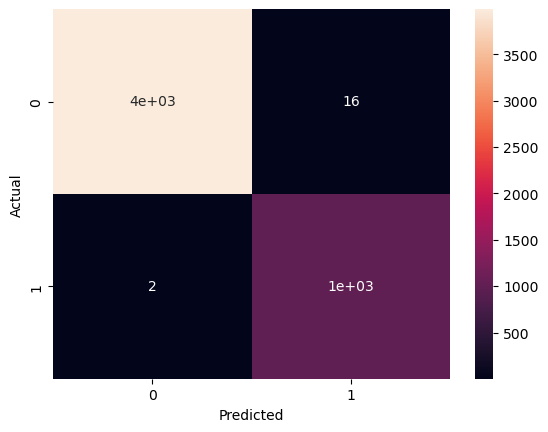

In [317]:
FP = df[(df.attack == False) & (df.attack_pred == True)][['attack']].count().values
TP = df[(df.attack == True) & (df.attack_pred == True)][['attack']].count().values
FN = df[(df.attack == True) & (df.attack_pred == False)][['attack']].count().values
TN = df[(df.attack == False) & (df.attack_pred == False)][['attack']].count().values

from sklearn.metrics import confusion_matrix
from seaborn import heatmap
print(f"Precision: {TP / (TP+FP)}")
print(f"Recall: {TP / (TP+FN)}")
cm = confusion_matrix(df.attack, df.attack_pred)
heatmap(data=cm, annot=True)
plt.xlabel("Predicted") 
plt.ylabel("Actual")

<Axes: xlabel='time', ylabel='attack_pred'>

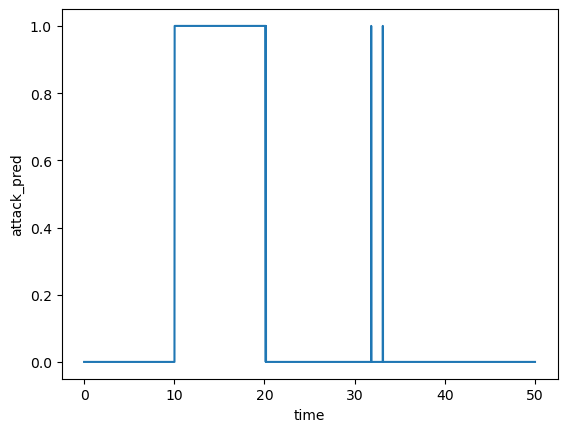

In [318]:
sns.lineplot(data=df, x='time', y='attack_pred')

<Axes: xlabel='time', ylabel='measured_vel'>

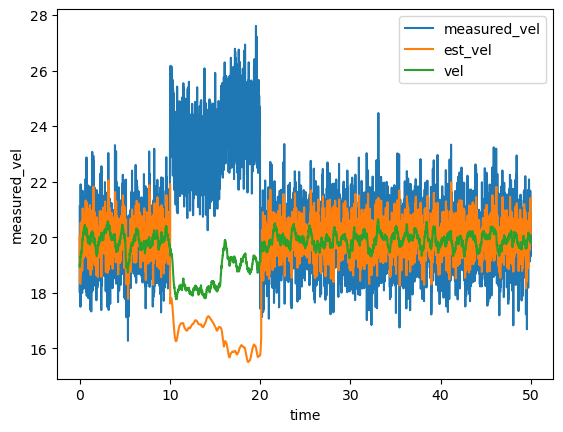

In [319]:
sns.lineplot(data=df, x='time', y='measured_vel', label="measured_vel")
sns.lineplot(data=df, x='time', y='est_vel', label="est_vel")
sns.lineplot(data=df, x='time', y='vel', label="vel")

<Axes: xlabel='time', ylabel='abs_est_error'>

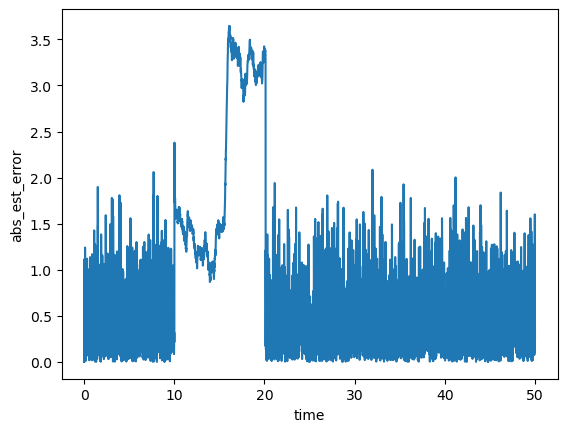

In [320]:
sns.lineplot(data=df, x='time', y='abs_est_error')

### CUSUM Tuning

In [254]:
%reload_ext autoreload
%autoreload 2
from control_systems.car_hillclimbing import HillClimbingCar
from pid_controller import PIDController
from anomaly_detection import CUSUMDetector
import numpy as np
from sklearn.metrics import f1_score
import pandas as pd

attack_magnitudes = [3, 5]
taus = np.arange(4, 6, 0.2)
best_f1 = float('-inf')
best_b, best_tau = -1, -1

for tau in taus:
    bs = np.arange(0.4, 0.6, 0.02)
    for b in bs:
        dfs = []
        for attack_mag in attack_magnitudes:
            env = HillClimbingCar()
            logger = env.run_control_system(config=
                {
                    "params": {
                        "m": 1200,       # Mass (kg)
                        "g": 9.81,       # Gravity (m/s^2)
                        "Cr": 0.01,      # Rolling resistance coefficient
                        "Cd": 0.3,       # Aerodynamic drag coefficient
                        "A": 2.2,        # Frontal area (m^2)
                        "rho": 1.225,    # Air density (kg/m^3)
                        "Fmax": 40000,    # Maximum engine force (N)
                    },
                    "init-state": np.array([0, 19]),  # [Position (m), Velocity (m/s)]
                    "dt": 0.01,
                    "time": 50,
                    "attack-start": 10,
                    "attack-end": 20,
                    "attack-magnitude": attack_mag,
                    "v-controller": PIDController(0.1, 0.5, 0.0), # PIDController(0.50320036, 0.50027134, 0.00711447), 
                    "target-velocity": 20,
                    "process-noise-cov": np.diag([0.001, 0.001]),
                    "measurement-noise-cov": 0.1,
                    "anomaly-detector": CUSUMDetector(
                        thresholds=np.array([tau]),
                        b=np.array([b])),
                },
                show_plots=False)
            
            df = pd.DataFrame(logger.data)
            dfs.append(df)
        
        df = pd.concat(dfs)
        f1 = f1_score(df.attack, df.attack_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_b = b
            best_tau = tau


In [255]:
best_f1

0.3345332775219757

In [256]:
best_b


0.5400000000000001

In [257]:
best_tau

5.400000000000001

### Performance Evaluation

In [369]:
%reload_ext autoreload
%autoreload 2
NBR_ITERATIONS = 50
dfs = []
env = HillClimbingCar()
for i in range(NBR_ITERATIONS):
    np.random.seed(1000-i)
    attack_magnitude = np.random.rand()*4 + 3
    attack_start_time = np.random.randint(40)
    attack_length = np.random.randint(40)
    attack_end_time = min(attack_start_time + attack_length, 50)

    logger = env.run_control_system(config=
                {
                    "params": {
                        "m": 1200,       # Mass (kg)
                        "g": 9.81,       # Gravity (m/s^2)
                        "Cr": 0.01,      # Rolling resistance coefficient
                        "Cd": 0.3,       # Aerodynamic drag coefficient
                        "A": 2.2,        # Frontal area (m^2)
                        "rho": 1.225,    # Air density (kg/m^3)
                        "Fmax": 40000,    # Maximum engine force (N)
                    },
                    "init-state": np.array([0, 19]),  # [Position (m), Velocity (m/s)]
                    "dt": 0.01,
                    "time": 50,
                    "attack-start": attack_start_time,
                    "attack-end": attack_end_time,
                    "attack-magnitude": attack_magnitude,
                    "v-controller": PIDController(0.1, 0.5, 0.0), # PIDController(0.50320036, 0.50027134, 0.00711447), 
                    "target-velocity": 20,
                    "process-noise-cov": np.diag([0.001, 0.001]),
                    "measurement-noise-cov": 0.1,
                    "anomaly-detector": CUSUMDetector(
                        thresholds=np.array([4.0]),
                        b=np.array([1.7])),
                },
                show_plots=False)
    df = pd.DataFrame(logger.data)
    df['attack_magnitude'] = attack_magnitude
    dfs.append(df)
        
df = pd.concat(dfs)
df.to_csv('./data/recovery_data_cusum.csv')

CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Updated
Updated
CUSUM Up

In [370]:
rec_df = pd.read_csv('./data/recovery_data.csv')
no_rec_df = pd.read_csv('./data/no_recovery_data.csv')
rec_df_c = pd.read_csv('./data/recovery_data_cusum.csv')

In [371]:
rec_df.head()

,Unnamed: 0,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred,attack_magnitude
0,0,0.00,0.000000,19.000000,0.000000,19.000000,19.744324,0.026846,False,False,5.614358
1,1,0.01,0.180488,19.019068,0.185278,19.375568,19.011631,0.105057,False,False,5.614358
2,2,0.02,0.355500,19.070704,0.380330,19.209977,18.706036,0.142086,False,False,5.614358
3,3,0.03,0.567309,19.090368,0.574211,18.980564,17.994298,0.223289,False,False,5.614358
4,4,0.04,0.745375,19.156822,0.767414,18.523527,19.360015,0.089917,False,False,5.614358


In [372]:
rec_df['reference_vel'] = 20
rec_df['control_error'] = rec_df['reference_vel'] - rec_df['vel']
rec_MSE = rec_df['control_error'].map(lambda x: x*x).mean()

rec_df_c['reference_vel'] = 20
rec_df_c['control_error'] = rec_df_c['reference_vel'] - rec_df_c['vel']
rec_MSE_c = rec_df_c['control_error'].map(lambda x: x*x).mean()

no_rec_df['reference_vel'] = 20
no_rec_df['control_error'] = no_rec_df['reference_vel'] - no_rec_df['vel']
norec_MSE = no_rec_df['control_error'].map(lambda x: x*x).mean()

print(f"MSE with Recovery: {rec_MSE}")
print(f"MSE with Recovery (Standard CUSUM): {rec_MSE_c}")
print(f"MSE without Recovery: {norec_MSE}")

MSE with Recovery: 5.405004450321171
MSE with Recovery (Standard CUSUM): 4.565507802138088
MSE without Recovery: 8.250811353571818


Text(50.722222222222214, 0.5, 'Actual')

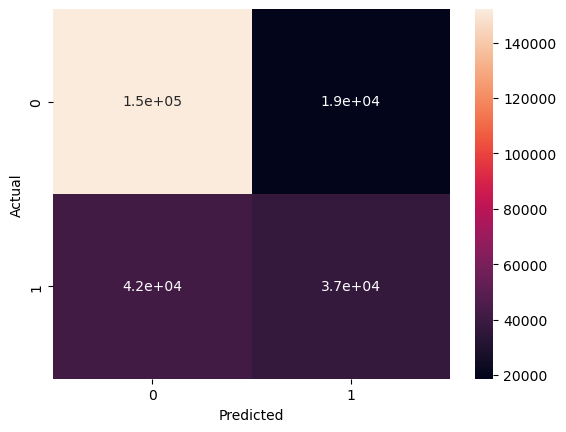

In [373]:
cm = confusion_matrix(rec_df.attack, rec_df.attack_pred)
heatmap(data=cm, annot=True)
plt.xlabel("Predicted") 
plt.ylabel("Actual")

In [374]:
from sklearn.metrics import recall_score, precision_score, accuracy_score
print(f"Accuracy: {accuracy_score(rec_df.attack, rec_df.attack_pred)}")
print(f"Precision: {precision_score(rec_df.attack, rec_df.attack_pred)}")
print(f"Recall: {recall_score(rec_df.attack, rec_df.attack_pred)}")

Accuracy: 0.757636
Precision: 0.6668454935622318
Recall: 0.47053034031116325


In [375]:
print(f"Accuracy: {accuracy_score(rec_df_c.attack, rec_df_c.attack_pred)}")
print(f"Precision: {precision_score(rec_df_c.attack, rec_df_c.attack_pred)}")
print(f"Recall: {recall_score(rec_df_c.attack, rec_df_c.attack_pred)}")

Accuracy: 0.684296
Precision: 0.5018214425825254
Recall: 0.5649140073942285


In [377]:
rec_df.describe()

,Unnamed: 0,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack_magnitude,reference_vel,control_error
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.0,250000.000000
mean,2499.500000,24.995000,481.811914,19.021431,490.595468,19.361820,20.638563,0.036413,4.858452,20.0,0.978569
std,1443.378531,14.433785,275.821530,2.108892,283.359136,1.665963,1.899243,0.119311,1.220813,0.0,2.108892
min,0.000000,0.000000,0.000000,11.656283,0.000000,12.098382,12.510017,-0.791489,3.024078,20.0,-8.291415
25%,1249.750000,12.497500,245.319232,17.456850,247.386236,19.073343,19.424012,-0.028163,3.791052,20.0,-0.018910
50%,2499.500000,24.995000,484.238208,19.739308,489.837771,19.824821,20.289017,0.022440,4.650859,20.0,0.260692
75%,3749.250000,37.492500,715.847750,20.018910,728.270802,20.330979,21.442593,0.108442,5.990710,20.0,2.543150
max,4999.000000,49.990000,1226.470990,28.291415,1119.170757,25.493203,30.814600,0.749136,6.973266,20.0,8.343717


### Uncertainty Plot

In [537]:
%reload_ext autoreload
%autoreload 2
NBR_ITERATIONS = 50
dfs = []
env = HillClimbingCar()
for i in range(NBR_ITERATIONS):
    np.random.seed(4232+i)
    logger = env.run_control_system(config=
                {
                    "params": {
                        "m": 1200,       # Mass (kg)
                        "g": 9.81,       # Gravity (m/s^2)
                        "Cr": 0.01,      # Rolling resistance coefficient
                        "Cd": 0.3,       # Aerodynamic drag coefficient
                        "A": 2.2,        # Frontal area (m^2)
                        "rho": 1.225,    # Air density (kg/m^3)
                        "Fmax": 40000,    # Maximum engine force (N)
                    },
                    "init-state": np.array([0, 19]),  # [Position (m), Velocity (m/s)]
                    "dt": 0.01,
                    "time": 50,
                    "attack-start": 10,
                    "attack-end": 30,
                    "attack-magnitude": 5,
                    "v-controller": PIDController(0.1, 0.5, 0.0), # PIDController(0.50320036, 0.50027134, 0.00711447), 
                    "target-velocity": 20,
                    "process-noise-cov": np.diag([0.001, 0.001]),
                    "measurement-noise-cov": 0.1,
                    "anomaly-detector": CUSUMDetector(
                        thresholds=np.array([6.921919851843655]), # 4.0 Before
                        b=np.array([1.1808196269817466])), # 1.7 Before
                },
                show_plots=False)
    df = pd.DataFrame(logger.data)
    df['attack_magnitude'] = attack_magnitude
    dfs.append(df)
        
df = pd.concat(dfs)
df.to_csv('./data/plot_recovery_tc_modified.csv')

Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated


In [538]:
df1 = pd.read_csv("./data/plot_no_recovery.csv")
df1.drop('Unnamed: 0', axis=1, inplace=True)
df1['reference_vel'] = 20
df1['control_error'] = df1['reference_vel'] - df1['vel']
df2 = pd.read_csv("./data/plot_recovery_tc_standard.csv")
df2.drop('Unnamed: 0', axis=1, inplace=True)
df2['reference_vel'] = 20
df2['control_error'] = df2['reference_vel'] - df2['vel']
df3 = pd.read_csv("./data/plot_recovery_tc_modified.csv")
df3.drop('Unnamed: 0', axis=1, inplace=True)
df3['reference_vel'] = 20
df3['control_error'] = df3['reference_vel'] - df3['vel']

Text(0.5, 1.0, 'Velocity over time under presense of Attack')

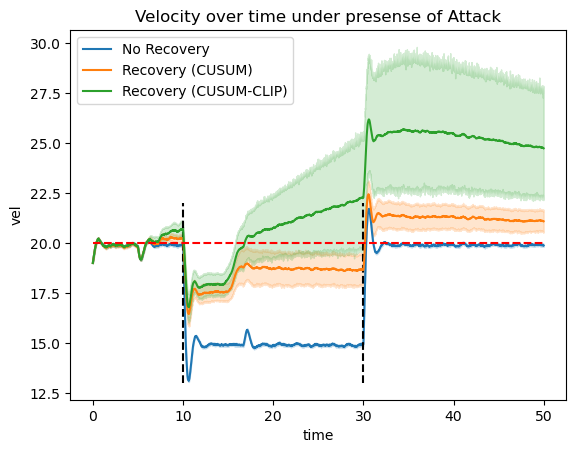

In [540]:
sns.lineplot(data=df1, x='time', y='vel', label="No Recovery")
plt.vlines(x=(10,30), ymin=(13,13), ymax=(22,22), color="black", linestyles="dashed")
sns.lineplot(data=df2, x='time', y='vel', label="Recovery (CUSUM)")
sns.lineplot(data=df3, x='time', y='vel', label="Recovery (CUSUM-CLIP)")
plt.hlines(y=20, xmin=0, xmax=50, color="red", linestyles="dashed")
plt.title("Velocity over time under presense of Attack")

Text(0.5, 1.0, 'Attack Prediction with CUSUM')

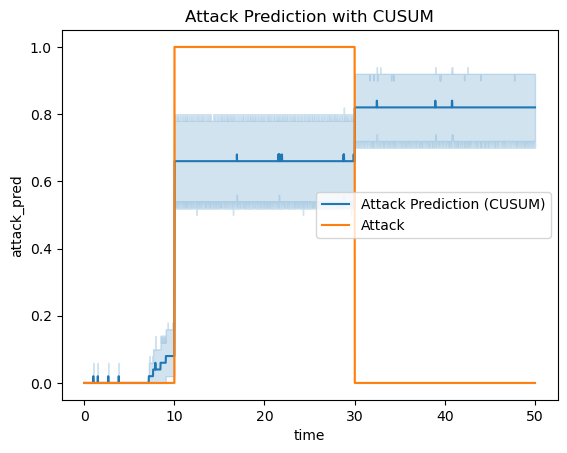

In [428]:
sns.lineplot(data=df2, x='time', y='attack_pred', label="Attack Prediction (CUSUM)")
sns.lineplot(data=df2, x='time', y='attack', label="Attack")
plt.title("Attack Prediction with CUSUM")

Text(0.5, 1.0, 'Attack Prediction with CUSUM-CLIP')

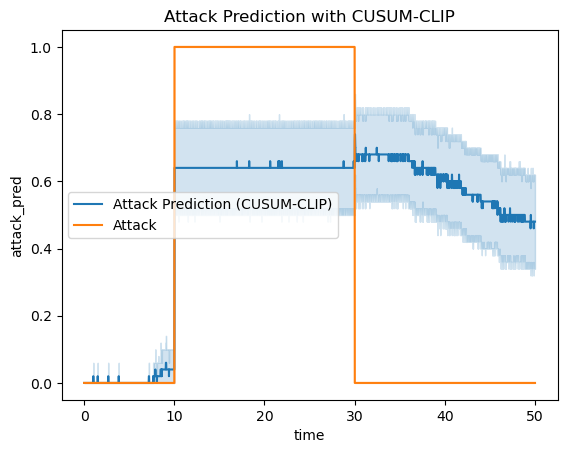

In [429]:
sns.lineplot(data=df3, x='time', y='attack_pred', label="Attack Prediction (CUSUM-CLIP)")
sns.lineplot(data=df3, x='time', y='attack', label="Attack")
plt.title("Attack Prediction with CUSUM-CLIP")

In [544]:
df2.head()

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred,attack_magnitude,reference_vel,control_error
0,0.00,0.000000,19.000000,0.000000,19.000000,18.239700,0.184831,False,False,5.319139,20,1.000000
1,0.01,0.213692,19.053421,0.195263,18.649523,19.866429,0.022826,False,False,5.319139,20,0.946579
2,0.02,0.416505,19.045351,0.377951,19.260728,19.575425,0.054050,False,False,5.319139,20,0.954649
3,0.03,0.573460,19.073699,0.569588,19.425976,19.233458,0.092079,False,False,5.319139,20,0.926301
4,0.04,0.732924,19.079648,0.764572,19.343933,19.976448,0.017898,False,False,5.319139,20,0.920352


In [547]:
df1.iloc[1000:1030]

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred,attack_magnitude,reference_vel,control_error,estimation_error
1000,10.00,199.357697,19.991827,199.765780,19.531668,21.800076,-0.045390,False,False,5.319139,20,0.008173,2.268408
1001,10.01,199.541398,19.896765,199.954468,20.632838,23.263535,-0.208054,True,False,5.319139,20,0.103235,2.630696
1002,10.02,199.761843,19.761631,200.152564,21.887989,24.565512,-0.361079,True,False,5.319139,20,0.238369,2.677523
1003,10.03,199.928610,19.593264,200.362418,23.140979,24.336961,-0.359909,True,False,5.319139,20,0.406736,1.195982
1004,10.04,200.108041,19.472064,200.589247,23.653285,23.504036,-0.294137,True,False,5.319139,20,0.527936,-0.149249
1005,10.05,200.297094,19.330612,200.825778,23.503872,23.801559,-0.342897,True,False,5.319139,20,0.669388,0.297687
1006,10.06,200.499625,19.211315,201.059239,23.569821,24.213607,-0.405169,True,False,5.319139,20,0.788685,0.643785
1007,10.07,200.693301,18.993245,201.292105,23.798445,22.653654,-0.262442,True,False,5.319139,20,1.006755,-1.144791
1008,10.08,200.883073,18.805090,201.533561,23.156509,24.320964,-0.450778,True,False,5.319139,20,1.194910,1.164455
1009,10.09,201.069220,18.610824,201.760551,23.637905,23.651459,-0.402085,True,False,5.319139,20,1.389176,0.013554


<Axes: xlabel='time', ylabel='estimation_error'>

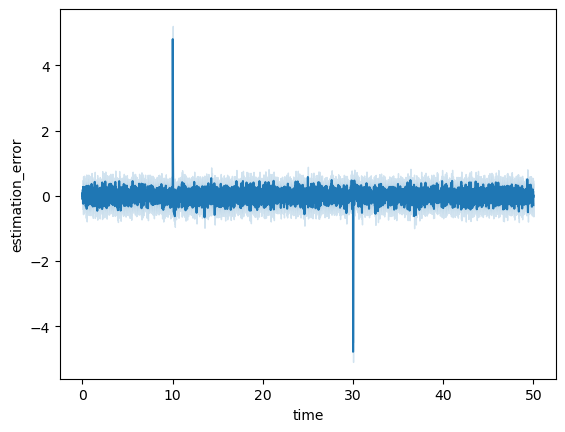

In [546]:
df1['estimation_error'] = df1['measured_vel'] - df1['est_vel']
sns.lineplot(data=df1, x='time', y='estimation_error')

### CUSUM Analysis

#### Estimate Residual Distribution (Attack Free)

In [9]:
%reload_ext autoreload
%autoreload 2
from control_systems.car_hillclimbing import HillClimbingCar
from pid_controller import PIDController
from anomaly_detection import CUSUMDetector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

NBR_ITERATIONS = 50
dfs = []
env = HillClimbingCar()
for i in range(NBR_ITERATIONS):
    np.random.seed(4232+i)
    logger = env.run_control_system(config=
                {
                    "params": {
                        "m": 1200,       # Mass (kg)
                        "g": 9.81,       # Gravity (m/s^2)
                        "Cr": 0.01,      # Rolling resistance coefficient
                        "Cd": 0.3,       # Aerodynamic drag coefficient
                        "A": 2.2,        # Frontal area (m^2)
                        "rho": 1.225,    # Air density (kg/m^3)
                        "Fmax": 7000,    # Maximum engine force (N)
                    },
                    "init-state": np.array([0, 19]),  # [Position (m), Velocity (m/s)]
                    "dt": 0.01,
                    "time": 50,
                    "attack-start": -10,
                    "attack-end": -30,
                    "attack-magnitude": 5,
                    "v-controller": PIDController(1.0, 1.0, 0.0), # PIDController(0.50320036, 0.50027134, 0.00711447), 
                    "target-velocity": 20,
                    "process-noise-cov": np.diag([0.001, 0.001]),
                    "measurement-noise-cov": 0.1,
                    "anomaly-detector": CUSUMDetector(
                        thresholds=np.array([4.0]),
                        b=np.array([1.7])),
                },
                show_plots=False)
    df = pd.DataFrame(logger.data)
    dfs.append(df)
        
df = pd.concat(dfs)
df.to_csv('./data/cusum_analysis_new.csv')

Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated
Updated


In [10]:
df.head()

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred
0,0.00,0.000000,19.000000,0.000000,19.000000,18.239700,1.000000,False,False
1,0.01,0.213692,19.050143,0.195241,18.647885,19.863152,0.155820,False,False
2,0.02,0.416472,19.043555,0.377923,19.259011,19.573629,0.449606,False,False
3,0.03,0.573409,19.080114,0.569569,19.428324,19.239873,0.790964,False,False
4,0.04,0.732937,19.101509,0.764614,19.356037,19.998308,0.032545,False,False


In [11]:
df['residual'] = df['measured_vel'] - df['est_vel']
df['abs_residual'] = df['residual'].map(np.abs)

<Axes: xlabel='residual', ylabel='Count'>

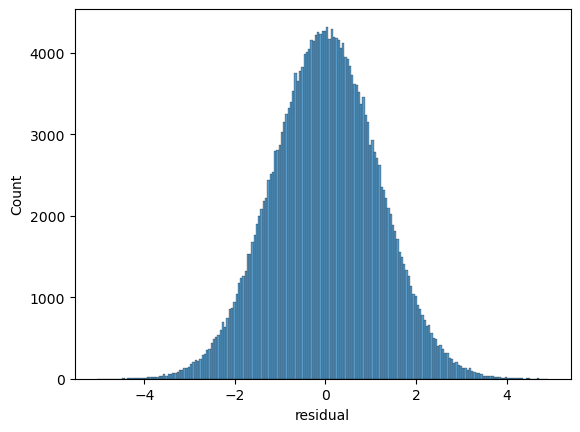

In [12]:
sns.histplot(data=df, x='residual')

<Axes: xlabel='abs_residual', ylabel='Count'>

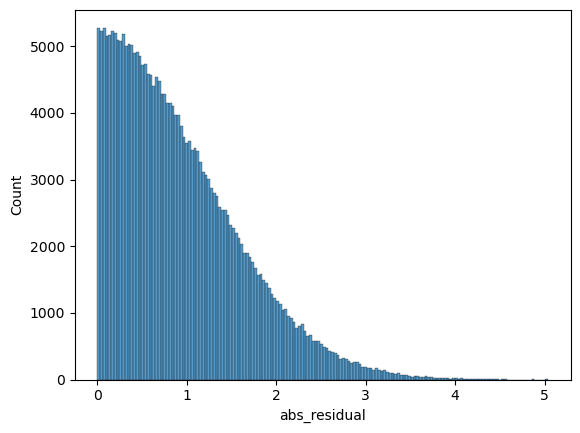

In [13]:
sns.histplot(data=df, x='abs_residual')

<BarContainer object of 14 artists>

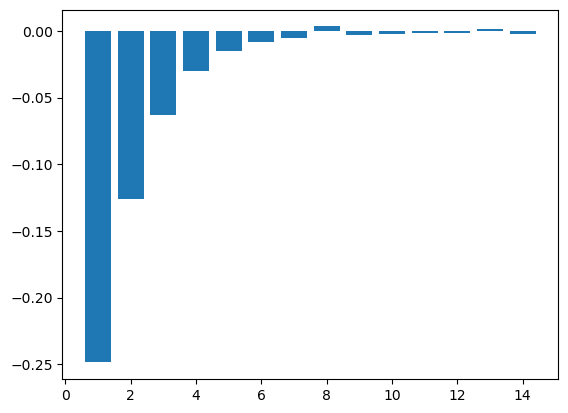

In [14]:
# Check for Autocorrelation
autocorrelations = [df.residual.autocorr(i) for i in range(1, 15)]
plt.bar(x=range(1,15), height=autocorrelations)

In [ ]:
# Fit a distribution to the residuals
from scipy import stats
bounds = [(-1, 1), (0, 5)]
res = stats.fit(stats.norm, df['residual'], bounds)

In [446]:
res

  params: FitParams(loc=0.0003070438153779743, scale=1.1680780822399834)
 success: True
 message: 'Optimization terminated successfully.'

<Axes: title={'center': 'Fitted $\\tt norm$ PDF and Histogram'}, xlabel='x', ylabel='PDF'>

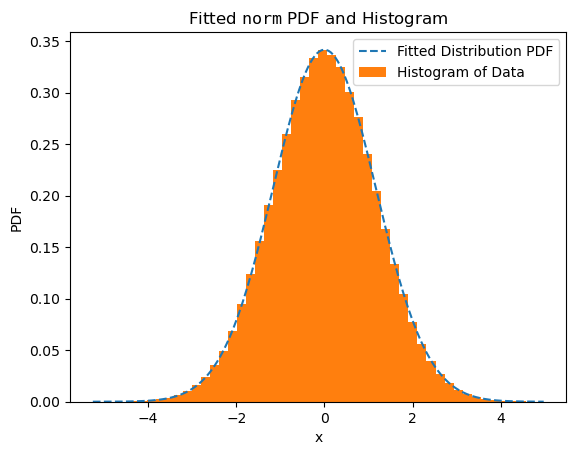

In [445]:
res.plot()

In [452]:
bounds = [(0, 10), (0, 10), (0, 10)]
fold_res = stats.fit(stats.foldnorm, df['abs_residual'], bounds)
fold_res

/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2401: RuntimeWarning: overflow encountered in divide
  x = (x - loc) / scale


  params: FitParams(c=0.20467697697212817, loc=1.8759792945743925e-06, scale=1.145089972542781)
 success: True
 message: 'Optimization terminated successfully.'

<Axes: title={'center': 'Fitted $\\tt foldnorm$ PDF and Histogram'}, xlabel='x', ylabel='PDF'>

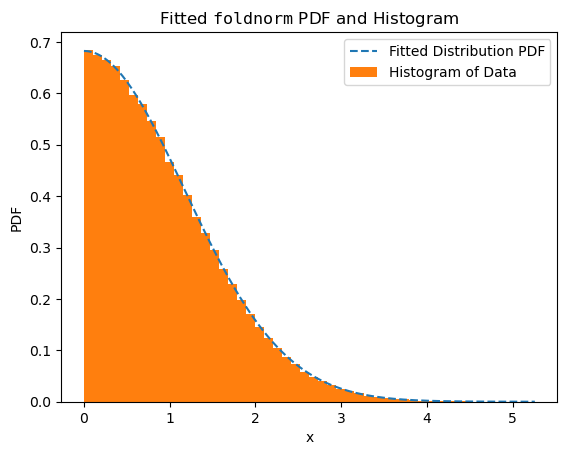

In [453]:
fold_res.plot()

In [480]:
x = stats.foldnorm(*fold_res.params)
print(f"Mean |measured vel. - estimated_vel| = {x.mean()}")
print(f"Var |measured vel. - estimated_vel| = {x.var()}")
x.rvs()


Mean |measured vel. - estimated_vel| = 0.9327225626643553
Var |measured vel. - estimated_vel| = 0.49619412863478274


0.11036460624874257

#### Estiamte Distribution of CUSUM Statistic (For Given $b = \mathbb{E}[e]+0.5\text{Var}[e]$)

In [466]:
# Get random sample of CUSUM Statistic
Ss = [0]
x = stats.foldnorm(*fold_res.params)
b = x.mean() + 0.5*x.var()

for t in range(1000000):
    sample = x.rvs()
    s = max(Ss[-1] + sample - b, 0)
    Ss.append(s)


<Axes: ylabel='Density'>

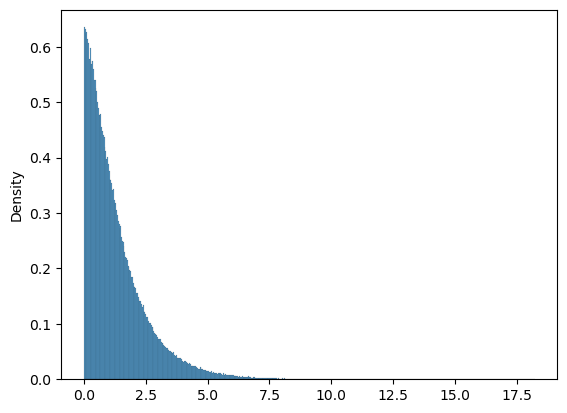

In [ ]:
filtered_s = list(filter(lambda x: x != 0, Ss))
sns.histplot(x=filtered_s, stat='density')

In [470]:
# Folded Normal Fit
cusum_foldnorm_params = stats.fit(stats.foldnorm, data=filtered_s, bounds=bounds)
cusum_foldnorm_params

  params: FitParams(c=0.02735195374110866, loc=7.422330412509837e-07, scale=1.8093066550872123)
 success: True
 message: 'Optimization terminated successfully.'

In [471]:
fold_res

  params: FitParams(c=0.20467697697212817, loc=1.8759792945743925e-06, scale=1.145089972542781)
 success: True
 message: 'Optimization terminated successfully.'

<Axes: title={'center': 'Fitted $\\tt foldnorm$ PDF and Histogram'}, xlabel='x', ylabel='PDF'>

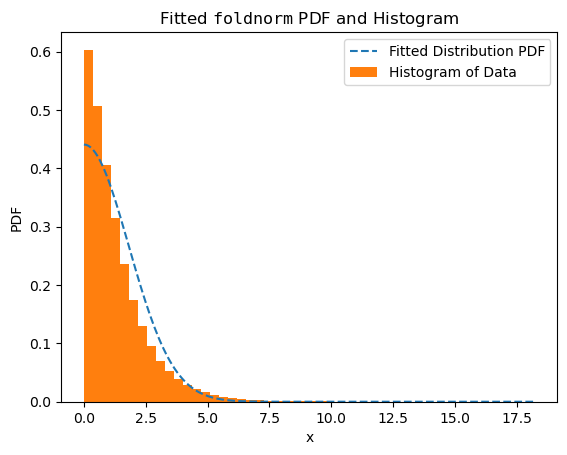

In [472]:
cusum_foldnorm_params.plot()

In [543]:
cusum_folded_dist = stats.foldnorm(*cusum_foldnorm_params.params)
cusum_folded_dist.ppf(0.995)

5.080683904601191

In [474]:
# Exponential Fit
bounds = [(0,10), (0,10)]
cusum_exp_params = stats.fit(dist=stats.expon, data=filtered_s, bounds=bounds)
cusum_exp_params

  params: FitParams(loc=4.5004088011779686e-07, scale=1.3064372937539885)
 success: True
 message: 'Optimization terminated successfully.'

<Axes: title={'center': 'Fitted $\\tt expon$ PDF and Histogram'}, xlabel='x', ylabel='PDF'>

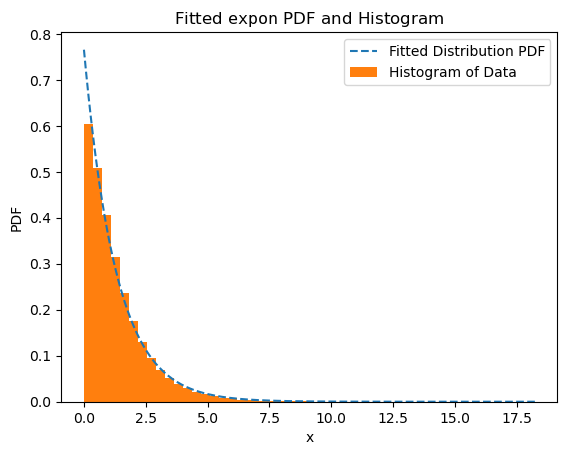

In [475]:
cusum_exp_params.plot()

In [481]:
len(filtered_s)

566725

In [482]:
len(Ss) - len(filtered_s)

433276

In [483]:
cusum_dist = stats.expon(*cusum_exp_params.params)
cusum_dist.ppf(0.95)

3.913736814314238

**Comment:** Given this $b$, the threshold $\tau$ should be set to $\tau = 3.913736814314238$, this ensures a false positive rate of 5%

In [484]:
cusum_dist = stats.expon(*cusum_exp_params.params)
cusum_dist.ppf(0.99)

6.016366525099714

**Comment:** Given this $b$, the threshold $\tau$ should be set to $\tau = 6.016366525099714$, this ensures a false positive rate of 1%

In [528]:
cusum_dist = stats.expon(*cusum_exp_params.params)
cusum_dist.ppf(0.995)

6.921919851843655

##### Goodness of fit Test

In [532]:
res_folded = stats.goodness_of_fit(stats.foldnorm, np.random.choice(filtered_s, 1000))
res_folded

GoodnessOfFitResult(fit_result=  params: FitParams(c=0.0010083417151329414, loc=0.0006880376617117203, scale=1.873567990970968)
 success: True
 message: 'The fit was performed successfully.', statistic=25.66169932717048, pvalue=0.0001, null_distribution=array([0.71170252, 0.29583892, 0.39780585, ..., 0.39668719, 0.39690933,
       0.75014763]))

In [534]:
res_exp = stats.goodness_of_fit(stats.expon, np.random.choice(filtered_s, 1000))
res_exp

/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/scipy/stats/_resampling.py:991: RuntimeWarning: invalid value encountered in scalar subtract
  cmps = null_distribution >= observed - gamma


GoodnessOfFitResult(fit_result=  params: FitParams(loc=0.0028114365111937545, scale=1.311443205371505)
 success: True
 message: 'The fit was performed successfully.', statistic=inf, pvalue=0.0001, null_distribution=array([inf, inf, inf, ..., inf, inf, inf]))

**Comment:** Goodness of fit test seems inconclusive but Exponential looks more reasonable if the histograms are considered.

#### Mean Time to Detection $\mathbb{E}[T]$

In [529]:
tau = 6.921919851843655
detection_times = []
prev_s = 0
for j in range(10000):
    attack_time = np.random.randint(0, 90)
    prev_s = 0
    s = 0
    for i in range(100):
        sample = x.rvs()
        if i >= attack_time:
            sample += 5
        s = max(prev_s + sample - b, 0)
        prev_s = s
        if s > tau:
            detection_times.append(i-attack_time)
            break
        
    if len(detection_times) != j+1:
        detection_times.append(float('inf'))

In [530]:
# Compute Mean Detection Time
f_dt = list(filter(lambda x: x >= 0, detection_times))
fps = list(filter(lambda x: x < 0, detection_times))
print(f"Expected Detection Time = {sum(f_dt) / len(f_dt)}")
print(f"False Positive Rate = {round((len(fps) / len(detection_times)), 4)*100}%")

Expected Detection Time = 0.8860925813624418
False Positive Rate = 1.06%


In [572]:
df_noattack = pd.read_csv("./data/cusum_analysis.csv")
df_noattack['est_error'] = df_noattack['measured_vel'] - df_noattack['est_vel']

In [575]:
correlation_data = [df_noattack.est_error.autocorr(i) for i in range(1, 15)]

Text(0, 0.5, 'Auto-Correlation')

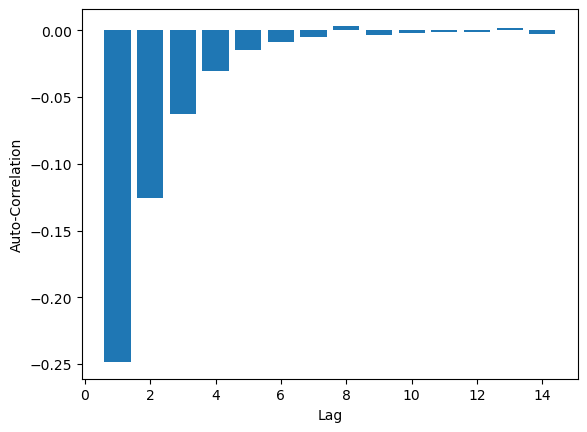

In [576]:
plt.bar(x=range(1,15), height=correlation_data)
plt.xlabel("Lag")
plt.ylabel("Auto-Correlation")